# Setup

## Imports

In [33]:
# Imports
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import scipy.io
import csv
import random
import torchvision.transforms as transforms
from ipywidgets import widgets, interact
from IPython.display import display
from numpy import vstack
from numpy import sqrt
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.nn import Sigmoid
from torch.nn import MSELoss
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from torch import Tensor
import torch.nn as nn
from torch.nn import BatchNorm2d
from torch.nn import Dropout2d
from torch.nn import Sequential
from torch.nn import Linear
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from torchvision.datasets import MNIST
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from livelossplot import PlotLosses
#from torchinfo import summary

np.random.seed(0) 
torch.manual_seed(0)
random.seed(0)

## GPU or CPU

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_default_device():
    if torch.cuda.is_available:
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data,(list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
         for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

device = get_default_device()

print(torch.cuda.is_available())
print(device)
print(torch.cuda.get_device_name(0))

True
cuda
NVIDIA GeForce RTX 3060 Ti


# Parâmetros

Definir constantes usadas ao longo do programa, e paths dos ficheiros contendo os datasets

In [35]:
# Constantes

BATCH_SIZE = 1

# Apenas alguns pixels serão selecionados para o treino da rede neuronal. Apenas aqueles com maior correlação com o atributo age
# Os INPUTS corresponde ao número de pixels com maior correlação positiva com o atributo age que serão selecionados
INPUTS = 100
# Os TAILS corresponde ao número de pixels com maior correlação negativa com o atributo age que serão selecionados
TAILS = 5

NON_PIXELS = 4 # indexes, age, sex, education | pixels...
ATRIBUTES_NON_PIXEL = 2
PIXELS = INPUTS + TAILS


#----------------------------------------------------------------------

AGE_MIN = 0
AGE_MAX = 100

# Classificação das faixas etárias
AGE_JOVEM = 20 # jovem até aos 30
AGE_IDOSO = 60 # idoso a partir dos 65

#----------------------------------------------------------------------
# Paths dos ficheiros


# Dataset com todos os dados disponibilizados
PATH_ALL = './all_data.csv'

# Datasets necessários para fazer as previsões
#PATH_TRAIN_MASC = './train_data_masc.csv'
#PATH_TEST_MASC = './test_data_masc.csv'
#PATH_TRAIN_FEM = './train_data_fem.csv'
#PATH_TEST_FEM = './test_data_fem.csv'
PATH_TRAIN = './train_data.csv'
PATH_TEST = './test_data.csv'

# Datasets necessários para fazer as previsões do Kaggle
PATH_ALL_KAGGLE = './all_data_kaggle.csv'
PATH_TEST_UNI_KAGGLE = './test_data_uni_kaggle.csv'
#PATH_TEST_MASC_KAGGLE = './test_data_masc_kaggle.csv'
#PATH_TEST_FEM_KAGGLE = './test_data_fem_kaggle.csv'

# Preparar ficheiros csv

In [36]:
train_mat = scipy.io.loadmat('train_data.mat') 
test_mat = scipy.io.loadmat('test_data.mat') 

In [37]:
def get_data_from_mat(train_file,test_file):
    train_mat = scipy.io.loadmat(train_file) 
    test_mat = scipy.io.loadmat(test_file) 
    print(train_mat.keys())
    print(test_mat.keys())
    train_np = np.array(train_mat['train_data']).transpose(2,0,1)
    test_np = np.array(test_mat['test_data']).transpose(2,0,1)
    print(train_np.shape)
    print(test_np.shape)
    return  train_np, test_np


train_data, test_data = get_data_from_mat('train_data.mat','test_data.mat')

dict_keys(['__header__', '__version__', '__globals__', 'train_data'])
dict_keys(['__header__', '__version__', '__globals__', 'test_data'])
(112, 90, 90)
(28, 90, 90)


In [38]:
# return dataframe from path
def readPath(path):
    df = pd.read_csv(path)
    return df

In [39]:
# ler info adicional sobre as pessoas (education and sex)

df = pd.read_csv('train.csv')
display(df.head()) 
#normalização education
#df_min_max_scaled = df.copy()        
# apply normalization techniques by Column 1
#column = 'education'
#df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())   
# view normalized data
#display(df_min_max_scaled)
#df_min_max_scaled.to_csv('train.csv', index=False)

#display(df_min_max_scaled.head()) 


df_kaggle = pd.read_csv('test.csv')
display(df_kaggle.head()) 

,id,age,sex,education
0,1,13,1,7
1,2,14,0,8
2,3,15,1,9
3,4,15,1,9
4,5,15,1,9


,id,sex,education
0,1,0,13
1,2,0,11
2,3,1,9
3,4,1,13
4,5,0,12


Contrução do ficheiro CSV com dados (info + matriz de conectividade) da pessoa

In [40]:
# open the file in the write mode
f_all = open(PATH_ALL, 'w', newline='')

# create the csv writer
writer_all = csv.writer(f_all)


atributes = ['index','age','education','sex']
for x in range(90*90):
    atributes = np.append(atributes,str(x))

writer_all.writerow(atributes)


# existem 112 registos no dataset de treino
for x in range(112):
    # obter os dados da structural connectivity matrix número x
    arr = np.array(train_data[x])
    # trasformar a matriz anterior para um array
    arr = arr.flatten()
    # print ("age do id ", x, ": ", df.at[x, 'age'])
    # adicionar o label no início de cada registo
    arr = np.insert(arr, 0,  df.at[x, 'sex'])
    arr = np.insert(arr, 0,  df.at[x, 'education'])
    arr = np.insert(arr, 0, df.at[x, 'age'])
    arr = np.insert(arr, 0, x)
    writer_all.writerow(arr.flatten())

f_all.close()

In [41]:
# open the file in the write mode
f_all = open(PATH_ALL_KAGGLE, 'w', newline='')

# create the csv writer
writer_all = csv.writer(f_all)

atributes = ['index','age','education','sex']
for x in range(90*90):
    atributes = np.append(atributes,str(x))

writer_all.writerow(atributes)


# existem 112 registos no dataset de treino
for x in range(28):
    # obter os dados da structural connectivity matrix número x
    arr = np.array(test_data[x])
    # trasformar a matriz anterior para um array
    arr = arr.flatten()
    # print ("age do id ", x, ": ", df.at[x, 'age'])
    # adicionar o label no início de cada registo
    arr = np.insert(arr, 0,  df.at[x, 'sex'])
    arr = np.insert(arr, 0,  df.at[x, 'education'])
    arr = np.insert(arr, 0, -1)
    arr = np.insert(arr, 0, x)
    writer_all.writerow(arr.flatten())

f_all.close()

In [42]:
def line_col(x):
    return int(x//90), int(x-(90*(x//90)))

lin,col = line_col(7464)
print(lin)
print(col)

82
84


# Visualização Matrix

In [43]:

def visualize(image):  
    plt.figure("sample", (20, 10))
    #plt.subplot(1, 2, 1)
    plt.imshow(image, cmap="viridis")    
    #plt.subplot(1, 2, 2)
    #plt.imshow(image, cmap="gray")
    plt.show()      


#@interact
def show_ds(ds):
    print("ds shape:",ds.shape)
    print("ds max:",np.max(ds))
    print("ds min:",np.min(ds))
    print("ds average:",np.average(ds))
    @interact
    def visualize_set(scan_index=(0,len(ds)-1)):
        visualize(ds[scan_index,:,:])


df = pd.read_csv("all_data.csv", header=0)
df = df.sort_values(by=['age'], ascending=True)
#df_sum = df
#df_sum["sum"] = df.iloc[: , 4:].sum(axis=1)
#sns.regplot(x=df_sum['age'], y= df_sum['sum'])
#display(df_sum)
df.drop('index', inplace=True, axis=1)
df.drop('age', inplace=True, axis=1)
df.drop('sex', inplace=True, axis=1)
df.drop('education', inplace=True, axis=1)

all_data = df.to_numpy().reshape(len(df), 90, 90)

show_ds(all_data)

ds shape: (112, 90, 90)
ds max: 1.0
ds min: 0.0
ds average: 0.024116160549305526


interactive(children=(IntSlider(value=55, description='scan_index', max=111), Output()), _dom_classes=('widget…

# Dataframes com os dados (info pessoa + conexões do cérebro) 

In [44]:
df = pd.read_csv("all_data.csv", header=0)
pd.set_option('display.max_rows', 200)
df = df.sort_values(by=['age'], ascending=True)



# remove simetric pixels
# pixels da imagem
indexes = np.arange(8100)
print(indexes)
print(indexes.dtype)
# pixels repetidos
list = []
repetidos = np.array(list)

for x in indexes:
    lin,col = line_col(x)
    if(lin > col): 
        repetidos = np.append(repetidos, x)

repetidos = repetidos.astype('int32')
print(repetidos)
print(repetidos.dtype)
indexes_to_drop = np.delete(indexes, repetidos)
indexes_to_drop = indexes_to_drop.astype('str')
print(indexes_to_drop)
df = df.drop(columns=indexes_to_drop)


# normalize education
df_min_max_scaled = df.copy()        
# apply normalization techniques by Column 1
column = 'education'
df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())   

repetidos = repetidos.astype('str')
for x in repetidos:
    df_min_max_scaled[x] = (df_min_max_scaled[x] - df_min_max_scaled[x].min()) / (df_min_max_scaled[x].max() - df_min_max_scaled[x].min()) 


# save dataframe
df_min_max_scaled.to_csv("all_data.csv", index=False)
# view normalized data
display(df_min_max_scaled)

[   0    1    2 ... 8097 8098 8099]
int32
[  90  180  181 ... 8096 8097 8098]
int32
['0' '1' '2' ... '8008' '8009' '8099']


,index,age,education,sex,90,180,181,270,271,272,...,8089,8090,8091,8092,8093,8094,8095,8096,8097,8098
0,0.0,13.0,0.35,1.0,NaN,0.196690,NaN,0.000000,0.115221,0.000000,...,NaN,NaN,0.000000,NaN,0.000000,NaN,0.254497,NaN,0.666226,NaN
1,1.0,14.0,0.40,0.0,NaN,0.140793,NaN,0.000000,0.087799,0.301283,...,NaN,NaN,0.000000,NaN,0.000000,NaN,0.314202,NaN,0.471853,NaN
2,2.0,15.0,0.45,1.0,NaN,0.294886,NaN,0.000000,0.312815,0.177970,...,NaN,NaN,0.000000,NaN,0.000000,NaN,0.442193,NaN,0.575497,NaN
3,3.0,15.0,0.45,1.0,NaN,0.252052,NaN,0.000000,0.292440,0.000000,...,NaN,NaN,0.000000,NaN,0.000000,NaN,0.161404,NaN,0.685579,NaN
4,4.0,15.0,0.45,1.0,NaN,0.317349,NaN,0.000000,0.358704,0.141288,...,NaN,NaN,0.000000,NaN,0.000000,NaN,0.167769,NaN,0.543102,NaN
5,5.0,15.0,0.45,1.0,NaN,0.264752,NaN,0.000000,0.343785,0.421596,...,NaN,NaN,0.000000,NaN,0.000000,NaN,0.304366,NaN,0.566813,NaN
13,13.0,15.0,0.45,1.0,NaN,0.191444,NaN,0.000000,0.235584,0.000000,...,NaN,NaN,0.000000,NaN,0.000000,NaN,0.215628,NaN,0.559323,NaN
15,15.0,15.0,0.45,1.0,NaN,0.472808,NaN,0.000000,0.759885,0.111277,...,NaN,NaN,0.000000,NaN,0.000000,NaN,0.428341,NaN,0.486271,NaN
10,10.0,15.0,0.45,1.0,NaN,0.274613,NaN,0.000000,0.173352,0.115260,...,NaN,NaN,0.000000,NaN,0.000000,NaN,0.519688,NaN,0.599808,NaN
14,14.0,16.0,0.50,1.0,NaN,0.095507,NaN,0.000000,0.111795,0.000000,...,NaN,NaN,0.000000,NaN,0.000000,NaN,0.265006,NaN,0.477262,NaN


In [45]:
df_kaggle = pd.read_csv(PATH_ALL_KAGGLE, header=0)
pd.set_option('display.max_rows', 200)
df_kaggle = df_kaggle.sort_values(by=['index'], ascending=True)

# remove simetric pixels
# pixels da imagem
indexes = np.arange(8100)
print(indexes)
print(indexes.dtype)
# pixels repetidos
list = []
repetidos = np.array(list)

for x in indexes:
    lin,col = line_col(x)
    if(lin > col): 
        repetidos = np.append(repetidos, x)

repetidos = repetidos.astype('int32')
print(repetidos)
print(repetidos.dtype)
indexes_to_drop = np.delete(indexes, repetidos)
indexes_to_drop = indexes_to_drop.astype('str')
print(indexes_to_drop)
df_kaggle = df_kaggle.drop(columns=indexes_to_drop)


test_indexes_kaggle_uni = df_kaggle['index'].to_numpy()
# normalize education
df_min_max_scaled = df_kaggle.copy()        
# apply normalization techniques by Column 1
column = 'education'
df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())   

repetidos = repetidos.astype('str')
for x in repetidos:
    df_min_max_scaled[x] = (df_min_max_scaled[x] - df_min_max_scaled[x].min()) / (df_min_max_scaled[x].max() - df_min_max_scaled[x].min()) 



df_min_max_scaled.to_csv(PATH_ALL_KAGGLE, index=False)
display(df_min_max_scaled)


[   0    1    2 ... 8097 8098 8099]
int32
[  90  180  181 ... 8096 8097 8098]
int32
['0' '1' '2' ... '8008' '8009' '8099']


,index,age,education,sex,90,180,181,270,271,272,...,8089,8090,8091,8092,8093,8094,8095,8096,8097,8098
0,0.0,-1.0,0.0,1.0,NaN,0.385406,NaN,0.000000,0.222628,0.279777,...,NaN,NaN,0.000000,NaN,0.000000,NaN,0.459329,NaN,0.000000,NaN
1,1.0,-1.0,0.1,0.0,NaN,0.429129,NaN,0.000000,0.207266,0.185021,...,NaN,NaN,0.000000,NaN,0.000000,NaN,0.598673,NaN,0.333798,NaN
2,2.0,-1.0,0.2,1.0,NaN,0.049846,NaN,0.000000,0.000000,0.302075,...,NaN,NaN,0.000000,NaN,0.000000,NaN,0.250440,NaN,0.273251,NaN
3,3.0,-1.0,0.2,1.0,NaN,0.078839,NaN,0.000000,0.121139,0.357091,...,NaN,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.020093,NaN
4,4.0,-1.0,0.2,1.0,NaN,0.308164,NaN,0.000000,0.214917,0.116829,...,NaN,NaN,0.000000,NaN,0.000000,NaN,0.327429,NaN,0.296300,NaN
5,5.0,-1.0,0.2,1.0,NaN,0.399695,NaN,0.000000,0.358244,0.301175,...,NaN,NaN,0.000000,NaN,0.000000,NaN,1.000000,NaN,0.299860,NaN
6,6.0,-1.0,0.3,0.0,NaN,0.319459,NaN,0.000000,0.318348,0.732645,...,NaN,NaN,0.000000,NaN,0.000000,NaN,0.459104,NaN,0.360830,NaN
7,7.0,-1.0,0.3,1.0,NaN,0.113449,NaN,0.000000,0.091128,1.000000,...,NaN,NaN,0.000000,NaN,0.304377,NaN,0.455990,NaN,0.397073,NaN
8,8.0,-1.0,0.3,0.0,NaN,1.000000,NaN,0.000000,1.000000,0.607329,...,NaN,NaN,0.491015,NaN,0.000000,NaN,0.434853,NaN,0.345613,NaN
9,9.0,-1.0,0.4,0.0,NaN,0.341646,NaN,0.000000,0.522116,0.458846,...,NaN,NaN,1.000000,NaN,0.000000,NaN,0.588937,NaN,0.367827,NaN


In [46]:
def indexesDataframe(path):
    df = pd.read_csv(path, header=0)
    return df['index'].to_numpy()

indexes = indexesDataframe(PATH_ALL_KAGGLE)
print(indexes)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27.]


A partir dos dados de treino criar: dados de treino e dados de validação

In [47]:
def train_test_split(path_train,path_test,atributes):
    f_train = open(path_train, 'w', newline='')
    # open the file in the write mode
    f_test = open(path_test, 'w', newline='')
    # create the csv writer
    writer_train = csv.writer(f_train)
    # create the csv writer
    writer_test = csv.writer(f_test)

    # escrever header
    for x in range(90*90):
        atributes = np.append(atributes,str(x))

    writer_train.writerow(atributes)
    writer_test.writerow(atributes)

    # indexes para validação
    val_indexes = [2, 3, 4 , 8, 7, 6, 11, 33, 35, 19, 36, 86, 90, 84, 13, 42]
    val_indexes = np.sort(val_indexes)
    
    
    df = pd.read_csv(PATH_ALL, header=0)
    df = df.sort_values(by=['age'], ascending=True)
    training_indexes = df['index'].to_numpy()
    training_indexes = training_indexes.astype(int)
    train_indexes = np.setdiff1d(training_indexes,val_indexes)

    train_data = pd.DataFrame()  
    test_data = pd.DataFrame()  

    # existem 112 registos no dataset de treino
    for x in training_indexes:
        x = int(x)
        row_to_append = df.loc[df['index'] == x]

        if x not in val_indexes:
            #arr = np.insert(arr, 0, 0)
            # write a row to the csv file
            train_data = train_data.append(row_to_append, ignore_index = True)
        else:
            test_data = test_data.append(row_to_append, ignore_index = True)

    train_data.to_csv(path_train, index=False)
    test_data.to_csv(path_test, index=False)

    #display(train_data)
    #display(test_data)

    return train_indexes,val_indexes 


atributes = ['index','age','education','sex']
#train_indexes_masc, val_indexes_masc = train_test_split('./train_data_masc.csv','./test_data_masc.csv',0,AGE_MIN,AGE_MAX,0)
#train_indexes_fem, val_indexes_fem = train_test_split('./train_data_fem.csv','./test_data_fem.csv',1,AGE_MIN,AGE_MAX,0)
train_indexes_uni, val_indexes_uni = train_test_split('./train_data.csv','./test_data.csv',atributes)
print(train_indexes_uni)
print(val_indexes_uni)


[  0   1   5   9  10  12  14  15  16  17  18  20  21  22  23  24  25  26
  27  28  29  30  31  32  34  37  38  39  40  41  43  44  45  46  47  48
  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  85
  87  88  89  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111]
[ 2  3  4  6  7  8 11 13 19 33 35 36 42 84 86 90]


In [48]:
readPath('./test_data.csv')

,index,age,education,sex,90,180,181,270,271,272,...,8089,8090,8091,8092,8093,8094,8095,8096,8097,8098
0,2.0,15.0,0.45,1.0,NaN,0.294886,NaN,0.0,0.312815,0.177970,...,NaN,NaN,0.000000,NaN,0.0,NaN,0.442193,NaN,0.575497,NaN
1,3.0,15.0,0.45,1.0,NaN,0.252052,NaN,0.0,0.292440,0.000000,...,NaN,NaN,0.000000,NaN,0.0,NaN,0.161404,NaN,0.685579,NaN
2,4.0,15.0,0.45,1.0,NaN,0.317349,NaN,0.0,0.358704,0.141288,...,NaN,NaN,0.000000,NaN,0.0,NaN,0.167769,NaN,0.543102,NaN
3,13.0,15.0,0.45,1.0,NaN,0.191444,NaN,0.0,0.235584,0.000000,...,NaN,NaN,0.000000,NaN,0.0,NaN,0.215628,NaN,0.559323,NaN
4,11.0,16.0,0.50,0.0,NaN,0.178703,NaN,0.0,0.325365,0.163890,...,NaN,NaN,0.000000,NaN,0.0,NaN,0.279959,NaN,0.556352,NaN
5,6.0,16.0,0.50,0.0,NaN,0.364587,NaN,0.0,0.181504,0.097724,...,NaN,NaN,0.000000,NaN,0.0,NaN,0.222275,NaN,0.439184,NaN
6,7.0,16.0,0.50,1.0,NaN,0.333006,NaN,0.0,0.201551,0.000000,...,NaN,NaN,0.000000,NaN,0.0,NaN,0.126700,NaN,0.609094,NaN
7,8.0,16.0,0.50,0.0,NaN,0.288176,NaN,0.0,0.199863,0.000000,...,NaN,NaN,0.000000,NaN,0.0,NaN,0.301295,NaN,0.361496,NaN
8,35.0,18.0,0.70,1.0,NaN,0.399851,NaN,0.0,0.198529,0.144518,...,NaN,NaN,0.000000,NaN,0.0,NaN,0.546891,NaN,0.639761,NaN
9,33.0,18.0,0.45,1.0,NaN,0.117303,NaN,0.0,0.174492,0.101797,...,NaN,NaN,0.000000,NaN,0.0,NaN,0.011521,NaN,0.467828,NaN


# TODO https://www.kaggle.com/competitions/trends-assessment-prediction/code
# TODO https://www.kaggle.com/code/rohitsingh9990/trends-eda-visualization-simple-baseline
# TODO normalizar todos os pixels

# Correlações entre o atributo age e os pixels

In [49]:

def correlation_Age_Pixels(inputs,tail):
    df = pd.read_csv("all_data.csv", header=0)

    # Selecionar o dataframe com apenas dados dos pixels
    df_sex_pixels = df.iloc[:, NON_PIXELS:]
    # Adicionar como primeira coluna o atributo age
    df_sex_pixels.insert (0, "age", df['age'])
    display(df_sex_pixels.head())

    # Obter as correlações entre todos os pixels e o atributo age
    corr = df_sex_pixels.corr()['age'][:]
    print(corr)

    coor_values = []
    # criar array em que para cada índice associo a correlação do atributo age com o pixel com número igual ao índice
    for x in corr[1:]:
        coor_values.append(x)
    
    indexes_corr = zip(repetidos, coor_values)
    print(indexes_corr) 

    # criar dataframe com os atributos indexes e correlação
    #indexes_corr = list(zip(repetidos, coor_values))  
    corr = pd.DataFrame(indexes_corr, columns=['indexes', 'correlation'])  
    corr = corr.sort_values(by=['correlation'], ascending=False)
    print('Correlação entre o atributo age e os pixels identificado pelo atributo indexes')
    #pd.set_option('display.max_rows', 200)
    # retirar atributos que não tem correlação com o atributo age
    corr.dropna(subset = ["correlation"], inplace=True)
    
    display(corr.head(INPUTS))
    display(corr.tail(TAILS))

    return pd.concat([corr.head(INPUTS), corr.tail(TAILS)])



# dataframe em que para cada index tenho associado a correlação entre o atributo age e o pixels com número igual ao índice
# são retornadas TODAS as correlações e em ordem descendente de valor de correlação
indexes_corr = correlation_Age_Pixels(INPUTS,TAILS)

,age,90,180,181,270,271,272,360,361,362,...,8089,8090,8091,8092,8093,8094,8095,8096,8097,8098
0,13.0,NaN,0.196690,NaN,0.0,0.115221,0.000000,NaN,NaN,0.644755,...,NaN,NaN,0.0,NaN,0.0,NaN,0.254497,NaN,0.666226,NaN
1,14.0,NaN,0.140793,NaN,0.0,0.087799,0.301283,NaN,NaN,0.416998,...,NaN,NaN,0.0,NaN,0.0,NaN,0.314202,NaN,0.471853,NaN
2,15.0,NaN,0.294886,NaN,0.0,0.312815,0.177970,NaN,NaN,0.296865,...,NaN,NaN,0.0,NaN,0.0,NaN,0.442193,NaN,0.575497,NaN
3,15.0,NaN,0.252052,NaN,0.0,0.292440,0.000000,NaN,NaN,0.491034,...,NaN,NaN,0.0,NaN,0.0,NaN,0.161404,NaN,0.685579,NaN
4,15.0,NaN,0.317349,NaN,0.0,0.358704,0.141288,NaN,NaN,0.320468,...,NaN,NaN,0.0,NaN,0.0,NaN,0.167769,NaN,0.543102,NaN


age     1.000000
90           NaN
180     0.410180
181          NaN
270     0.196307
          ...   
8094         NaN
8095    0.362696
8096         NaN
8097    0.105780
8098         NaN
Name: age, Length: 4006, dtype: float64
Correlação entre o atributo age e os pixels identificado pelo atributo indexes


,indexes,correlation
3568,7642,0.760659
3878,7970,0.728981
2869,6859,0.723977
3514,7588,0.704301
2633,6575,0.701963
3967,8061,0.679170
2250,6069,0.677263
3739,7824,0.667969
2780,6755,0.666162
2560,6484,0.663732


,indexes,correlation
2483,6368,-0.312232
3971,8065,-0.314345
2555,6460,-0.350530
2669,6611,-0.364396
723,3440,-0.433299


Apagar os pixels que tenham pouca correlação com o atributo age. Para que o modelo não seja influenciado por atributos que não dão muita informação sobre a age

In [50]:
display(indexes_corr['indexes'].count())

105

In [51]:
def apagar_pixels(indexes_corr,path_file):
    df = pd.read_csv(path_file, header=0)

    indexes_to_remove = np.setdiff1d(repetidos,indexes_corr.iloc[:, :]['indexes'].to_numpy())
    print(indexes_corr.iloc[:, :]['indexes'].to_numpy())
    # para todas os pixels que tem pouca correlação (todos aqueles que não estão nos INPUTS pixels com mais correlação positiva e nos TAILS com maior correlação negativa
    for x in indexes_to_remove:
        # remover pixel que não têm impacto no modelo
        df.drop(str(x), inplace=True, axis=1)
        # colocar os valores de um certo pixel a zero
        #df.loc[(df[str(x)] > 0) & (df[str(x)] < 1), str(x)] = 0

    df.to_csv(path_file, index=False)


apagar_pixels(indexes_corr,'./train_data.csv')
apagar_pixels(indexes_corr,'./test_data.csv')
apagar_pixels(indexes_corr,PATH_ALL_KAGGLE)

['7642' '7970' '6859' '7588' '6575' '8061' '6069' '7824' '6755' '6484'
 '6821' '6753' '6662' '902' '6579' '7733' '5400' '6664' '7475' '7835'
 '7766' '6843' '3909' '6498' '6914' '7723' '7564' '4635' '6875' '6499'
 '3818' '7744' '6773' '7005' '7699' '6730' '6775' '6906' '6965' '6482'
 '5990' '6573' '2702' '2721' '7384' '5547' '3000' '2720' '7408' '7754'
 '6502' '2882' '7363' '5907' '7612' '7715' '6063' '6421' '7006' '2524'
 '6678' '2814' '2180' '7776' '7497' '7679' '1630' '6330' '6996' '1082'
 '6595' '2365' '7560' '7901' '1620' '7576' '6682' '2810' '5491' '5978'
 '6953' '5068' '6948' '7857' '6862' '2522' '7867' '6593' '6506' '7713'
 '7966' '4993' '5970' '1264' '993' '7768' '7624' '8075' '8059' '2077'
 '6368' '8065' '6460' '6611' '3440']
['7642' '7970' '6859' '7588' '6575' '8061' '6069' '7824' '6755' '6484'
 '6821' '6753' '6662' '902' '6579' '7733' '5400' '6664' '7475' '7835'
 '7766' '6843' '3909' '6498' '6914' '7723' '7564' '4635' '6875' '6499'
 '3818' '7744' '6773' '7005' '7699' '6730' 

In [52]:
df = readPath('./train_data.csv')
display(df)

,index,age,education,sex,902,993,1082,1264,1620,1630,...,7835,7857,7867,7901,7966,7970,8059,8061,8065,8075
0,0.0,13.0,0.35,1.0,0.000000,0.000000,0.000000,0.168387,0.137683,0.000000,...,0.109896,0.065298,0.096253,0.468688,0.270680,0.088598,0.000000,0.134527,0.243906,0.119003
1,1.0,14.0,0.40,0.0,0.000000,0.000000,0.000000,0.435072,0.224825,0.000000,...,0.000000,0.111106,0.233085,0.000000,0.000000,0.061549,0.000000,0.214885,0.321007,0.253611
2,5.0,15.0,0.45,1.0,0.000000,0.083459,0.071926,0.616756,0.144267,0.000000,...,0.000000,0.000000,0.126227,0.000000,0.000000,0.143723,0.139704,0.137526,0.559367,0.127564
3,15.0,15.0,0.45,1.0,0.063996,0.000000,0.000000,0.291706,0.059996,0.000000,...,0.000000,0.000000,0.172706,0.000000,0.000000,0.179948,0.374418,0.378647,0.298538,0.198224
4,10.0,15.0,0.45,1.0,0.000000,0.000000,0.000000,0.422724,0.051793,0.000000,...,0.000000,0.000000,0.265276,0.000000,0.000000,0.226913,0.000000,0.141572,0.480517,0.000000
5,17.0,16.0,0.50,1.0,0.000000,0.000000,0.000000,0.320254,0.110001,0.000000,...,0.000000,0.000000,0.166115,0.000000,0.000000,0.093868,0.000000,0.162421,0.321927,0.000000
6,18.0,16.0,0.50,0.0,0.000000,0.098125,0.054212,0.245611,0.174408,0.000000,...,0.076936,0.000000,0.203773,0.000000,0.000000,0.000000,0.000000,0.183444,0.018692,0.000000
7,12.0,16.0,0.50,0.0,0.000000,0.116723,0.092167,0.117476,0.138699,0.000000,...,0.000000,0.000000,0.118340,0.000000,0.000000,0.173665,0.000000,0.196560,0.548486,0.106613
8,14.0,16.0,0.50,1.0,0.000000,0.000000,0.000000,0.377876,0.000000,0.000000,...,0.000000,0.000000,0.106162,0.000000,0.000000,0.000000,0.000000,0.000000,0.144610,0.000000
9,16.0,17.0,0.55,1.0,0.059533,0.000000,0.000000,0.286886,0.145279,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.142544,0.000000,0.101568,0.118420,0.128715


# Visualização 

## Correlação entre o atributo age e as conexões entre as regiões do cérebro

<AxesSubplot:xlabel='age', ylabel='7642'>

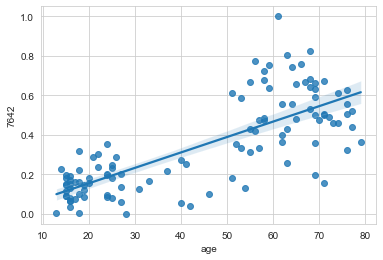

In [53]:
import seaborn as sns

df = pd.read_csv("all_data.csv", header=0)
#df = df[df['education'] == 4]
#df = df[df['education'] < 10]
#df = df[df['sex'] == SEX]
#df = df[df['age'] == 15]
#df = df[df['age'] > AGE_MIN ]
#df = df[df['age'] < AGE_MAX ]
#df = df.sort_values(by=['age'], ascending=True)

# use the function regplot to make a scatterplot
sns.regplot(x=df['age'], y= df['7642'])


## Matrizes de conectividade

In [54]:
display(df)

,index,age,education,sex,90,180,181,270,271,272,...,8089,8090,8091,8092,8093,8094,8095,8096,8097,8098
0,0.0,13.0,0.35,1.0,NaN,0.196690,NaN,0.000000,0.115221,0.000000,...,NaN,NaN,0.000000,NaN,0.000000,NaN,0.254497,NaN,0.666226,NaN
1,1.0,14.0,0.40,0.0,NaN,0.140793,NaN,0.000000,0.087799,0.301283,...,NaN,NaN,0.000000,NaN,0.000000,NaN,0.314202,NaN,0.471853,NaN
2,2.0,15.0,0.45,1.0,NaN,0.294886,NaN,0.000000,0.312815,0.177970,...,NaN,NaN,0.000000,NaN,0.000000,NaN,0.442193,NaN,0.575497,NaN
3,3.0,15.0,0.45,1.0,NaN,0.252052,NaN,0.000000,0.292440,0.000000,...,NaN,NaN,0.000000,NaN,0.000000,NaN,0.161404,NaN,0.685579,NaN
4,4.0,15.0,0.45,1.0,NaN,0.317349,NaN,0.000000,0.358704,0.141288,...,NaN,NaN,0.000000,NaN,0.000000,NaN,0.167769,NaN,0.543102,NaN
5,5.0,15.0,0.45,1.0,NaN,0.264752,NaN,0.000000,0.343785,0.421596,...,NaN,NaN,0.000000,NaN,0.000000,NaN,0.304366,NaN,0.566813,NaN
6,13.0,15.0,0.45,1.0,NaN,0.191444,NaN,0.000000,0.235584,0.000000,...,NaN,NaN,0.000000,NaN,0.000000,NaN,0.215628,NaN,0.559323,NaN
7,15.0,15.0,0.45,1.0,NaN,0.472808,NaN,0.000000,0.759885,0.111277,...,NaN,NaN,0.000000,NaN,0.000000,NaN,0.428341,NaN,0.486271,NaN
8,10.0,15.0,0.45,1.0,NaN,0.274613,NaN,0.000000,0.173352,0.115260,...,NaN,NaN,0.000000,NaN,0.000000,NaN,0.519688,NaN,0.599808,NaN
9,14.0,16.0,0.50,1.0,NaN,0.095507,NaN,0.000000,0.111795,0.000000,...,NaN,NaN,0.000000,NaN,0.000000,NaN,0.265006,NaN,0.477262,NaN


# Construção da rede neuronal

## Preparação dos dados

In [55]:
class CSVDataset(Dataset):

    def __init__(self, path, transform=None):
        self.transform = transform
    
        # ler dataframe
        df = pd.read_csv(path, header=0)
        display(df)
        
        # selecionar os atributos para treino do modelo
        # 4 porque é a partir dessa coluna que começa os pixels da imagem

        #display(df_set.iloc[:,1:2])
        #print(len(indexes_corr_indexes))

        # definir o número de atributos para treino
        self.inputs = PIXELS + ATRIBUTES_NON_PIXEL
        df_temp = df.iloc[:, 2:]
        #display(df_temp)

        #self.x = df_set.values[:, ATRIBUTES_NOT_PIXELS:]
        self.x = df_temp.values
        #display(len(df_set.iloc[:, ATRIBUTES_NOT_PIXELS:].columns))
        #df_temp = pd.concat([df_set.iloc[:,ATRIBUTES_NOT_PIXELS:], df_set.iloc[:,1:2]], axis=1, join='inner')
        #self.x = df_temp.values
        #display(df_set.iloc[:,ATRIBUTES_NOT_PIXELS:])
        #print(self.x.shape)
        # 3 corresponde à coluna com a idade
        self.y = df.values[:, 1]
        self.x = self.x.astype('float32')
        self.y = self.y.astype('long')
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        label = self.y[idx]
        image = self.x[idx]       
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    
    def get_TensorDataset(self):
        # os últimos parâmetros correspondem ao shape do train_data.mat. como são imagens 90 por 90...
        x = self.x.reshape(len(self.x), 1, self.inputs)
        xmax, xmin = x.max(), x.min()
        x = (x-xmin)/(xmax - xmin)
        x  = torch.from_numpy(np.array(x)).float()
        y  = torch.from_numpy(np.array(self.y)).type(torch.LongTensor)
        cases = torch.utils.data.TensorDataset(x,y)
        return cases 

def prepare_data_loaders(path_train, path_test):
    #dataset_train = CSVDataset(path_train,transform=train_transform)
    dataset_train = CSVDataset(path_train)
    #dataset_test = CSVDataset(path_test,transform=test_transform)
    dataset_test = CSVDataset(path_test)
    train = dataset_train.get_TensorDataset()
    validation = dataset_test.get_TensorDataset()
    #train_size = int(0.95 * len(train)) # mexer com o size dos dados de treino e de teste
    #val_size = len(train) - train_size
    #train, validation = random_split(train, [train_size, val_size], generator=torch.Generator().manual_seed(2020))
    #test = dataset_test.get_TensorDataset()
    train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=False)
    val_dl = DataLoader(validation, batch_size=BATCH_SIZE, shuffle=False)
    #test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
    val_dl_all = DataLoader(validation, batch_size=len(validation), shuffle=False)
    #test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)
    return train_dl, val_dl,  train_dl_all, val_dl_all


def prepare_data_loader_kaggle(path_test):
    dataset_test = CSVDataset(path_test)
    test = dataset_test.get_TensorDataset()
    test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)
    return test_dl


#train_dl_masc, val_dl_masc, train_dl_all_masc, val_dl_all_masc = prepare_data_loaders(PATH_TRAIN_MASC, PATH_TEST_MASC)
#train_dl_fem, val_dl_fem, train_dl_all_fem, val_dl_all_fem = prepare_data_loaders(PATH_TRAIN_FEM, PATH_TEST_FEM)
train_dl_uni, val_dl_uni, train_dl_all_uni, val_dl_all_uni = prepare_data_loaders(PATH_TRAIN, PATH_TEST)
test_dl_uni = prepare_data_loader_kaggle(PATH_ALL_KAGGLE)


#test_dl_masc = prepare_data_loader_kaggle(PATH_TEST_MASC_KAGGLE)
#test_dl_fem = prepare_data_loader_kaggle(PATH_TEST_FEM_KAGGLE)


,index,age,education,sex,902,993,1082,1264,1620,1630,...,7835,7857,7867,7901,7966,7970,8059,8061,8065,8075
0,0.0,13.0,0.35,1.0,0.000000,0.000000,0.000000,0.168387,0.137683,0.000000,...,0.109896,0.065298,0.096253,0.468688,0.270680,0.088598,0.000000,0.134527,0.243906,0.119003
1,1.0,14.0,0.40,0.0,0.000000,0.000000,0.000000,0.435072,0.224825,0.000000,...,0.000000,0.111106,0.233085,0.000000,0.000000,0.061549,0.000000,0.214885,0.321007,0.253611
2,5.0,15.0,0.45,1.0,0.000000,0.083459,0.071926,0.616756,0.144267,0.000000,...,0.000000,0.000000,0.126227,0.000000,0.000000,0.143723,0.139704,0.137526,0.559367,0.127564
3,15.0,15.0,0.45,1.0,0.063996,0.000000,0.000000,0.291706,0.059996,0.000000,...,0.000000,0.000000,0.172706,0.000000,0.000000,0.179948,0.374418,0.378647,0.298538,0.198224
4,10.0,15.0,0.45,1.0,0.000000,0.000000,0.000000,0.422724,0.051793,0.000000,...,0.000000,0.000000,0.265276,0.000000,0.000000,0.226913,0.000000,0.141572,0.480517,0.000000
5,17.0,16.0,0.50,1.0,0.000000,0.000000,0.000000,0.320254,0.110001,0.000000,...,0.000000,0.000000,0.166115,0.000000,0.000000,0.093868,0.000000,0.162421,0.321927,0.000000
6,18.0,16.0,0.50,0.0,0.000000,0.098125,0.054212,0.245611,0.174408,0.000000,...,0.076936,0.000000,0.203773,0.000000,0.000000,0.000000,0.000000,0.183444,0.018692,0.000000
7,12.0,16.0,0.50,0.0,0.000000,0.116723,0.092167,0.117476,0.138699,0.000000,...,0.000000,0.000000,0.118340,0.000000,0.000000,0.173665,0.000000,0.196560,0.548486,0.106613
8,14.0,16.0,0.50,1.0,0.000000,0.000000,0.000000,0.377876,0.000000,0.000000,...,0.000000,0.000000,0.106162,0.000000,0.000000,0.000000,0.000000,0.000000,0.144610,0.000000
9,16.0,17.0,0.55,1.0,0.059533,0.000000,0.000000,0.286886,0.145279,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.142544,0.000000,0.101568,0.118420,0.128715


,index,age,education,sex,902,993,1082,1264,1620,1630,...,7835,7857,7867,7901,7966,7970,8059,8061,8065,8075
0,2.0,15.0,0.45,1.0,0.000000,0.000000,0.081110,0.196742,0.134031,0.000000,...,0.000000,0.000000,0.126030,0.000000,0.000000,0.082875,0.000000,0.283487,0.561082,0.169298
1,3.0,15.0,0.45,1.0,0.057945,0.306011,0.000000,0.195355,0.129197,0.000000,...,0.000000,0.112238,0.203413,0.204877,0.000000,0.072761,0.000000,0.127858,0.389048,0.120624
2,4.0,15.0,0.45,1.0,0.000000,0.000000,0.000000,0.483511,0.138522,0.000000,...,0.000000,0.000000,0.218265,0.000000,0.000000,0.143772,0.000000,0.130312,0.362707,0.131806
3,13.0,15.0,0.45,1.0,0.000000,0.000000,0.000000,0.584435,0.064885,0.000000,...,0.000000,0.111036,0.080723,0.000000,0.000000,0.114785,0.129984,0.286900,0.369372,0.110982
4,11.0,16.0,0.50,0.0,0.000000,0.085288,0.000000,0.236828,0.106316,0.000000,...,0.136883,0.151444,0.215444,0.000000,0.000000,0.083892,0.000000,0.084779,0.200506,0.000000
5,6.0,16.0,0.50,0.0,0.148861,0.067760,0.000000,0.324140,0.107250,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.058062,0.000000,0.296447,0.372396,0.174737
6,7.0,16.0,0.50,1.0,0.000000,0.000000,0.232615,0.269798,0.182354,0.000000,...,0.000000,0.061248,0.054272,0.000000,0.000000,0.092080,0.000000,0.098555,0.321416,0.000000
7,8.0,16.0,0.50,0.0,0.000000,0.092016,0.065352,0.276681,0.129139,0.000000,...,0.000000,0.000000,0.092692,0.000000,0.629952,0.095014,0.155794,0.254677,0.267269,0.103805
8,35.0,18.0,0.70,1.0,0.000000,0.092571,0.000000,0.294284,0.057498,0.000000,...,0.000000,0.053401,0.130171,0.000000,0.000000,0.000000,0.000000,0.270626,0.657686,0.139779
9,33.0,18.0,0.45,1.0,0.000000,0.094761,0.000000,0.395870,0.083023,0.000000,...,0.155431,0.136035,0.372574,0.000000,0.119187,0.000000,0.000000,0.111093,0.307862,0.000000


,index,age,education,sex,902,993,1082,1264,1620,1630,...,7835,7857,7867,7901,7966,7970,8059,8061,8065,8075
0,0.0,-1.0,0.0,1.0,0.215418,0.339877,0.164250,0.281678,0.324179,0.220479,...,0.000000,0.000000,0.041338,0.000000,0.000000,0.155537,0.000000,0.000000,0.557260,0.000000
1,1.0,-1.0,0.1,0.0,0.191308,0.059168,0.197602,0.276629,0.305995,0.199956,...,0.000000,0.075690,0.267427,0.215483,0.000000,0.140602,0.000000,0.160340,0.482916,0.110158
2,2.0,-1.0,0.2,1.0,0.060704,0.080630,0.110285,0.416421,0.045409,0.000000,...,0.000000,0.072094,0.097825,0.000000,0.391813,0.126529,0.000000,0.177130,0.239643,0.377495
3,3.0,-1.0,0.2,1.0,0.000000,0.000000,0.137087,0.199872,0.000000,0.000000,...,0.182697,0.170674,0.117071,0.198143,0.000000,0.000000,0.000000,0.136435,0.496782,0.000000
4,4.0,-1.0,0.2,1.0,0.193607,0.093897,0.190239,0.000000,0.181894,0.166592,...,0.000000,0.000000,0.103238,0.000000,0.000000,0.119238,0.000000,0.169866,0.820516,0.120640
5,5.0,-1.0,0.2,1.0,0.000000,0.000000,0.000000,0.057492,0.191250,0.000000,...,0.000000,0.112812,0.053323,0.000000,0.142894,0.102369,0.000000,0.034946,0.654427,0.084161
6,6.0,-1.0,0.3,0.0,0.156217,0.329659,0.310292,0.659072,0.570500,0.172917,...,0.782007,1.000000,0.564008,0.000000,0.000000,0.795833,0.340636,0.255889,0.898911,0.285550
7,7.0,-1.0,0.3,1.0,0.377586,0.059263,0.154298,0.496322,0.107282,0.159328,...,0.246642,0.571984,0.879340,0.158740,0.845259,0.159438,0.000000,0.126286,0.510129,0.188348
8,8.0,-1.0,0.3,0.0,0.549498,0.515875,0.307132,0.555075,0.620494,0.661092,...,0.181859,0.194149,0.338629,0.965939,0.237824,0.313457,0.641893,0.519532,0.424045,0.314088
9,9.0,-1.0,0.4,0.0,0.445594,0.675524,0.467864,0.384055,0.762228,0.774421,...,0.487383,0.526122,0.483623,0.211272,0.377242,0.590007,1.000000,0.473923,0.338054,0.106083


## Balanceamento do Target

-----------------------------------casos_treino_feminimo-----------------------------------
casos: 96
número de labels diferentes:  48


c:\Users\jlame\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


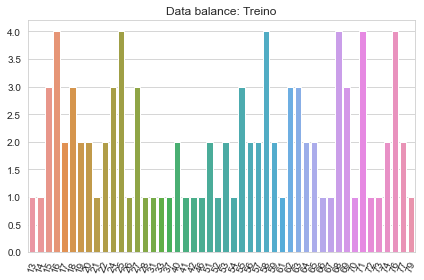

-----------------------------------casos_validação_feminimo-----------------------------------
casos: 16
número de labels diferentes:  6


c:\Users\jlame\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


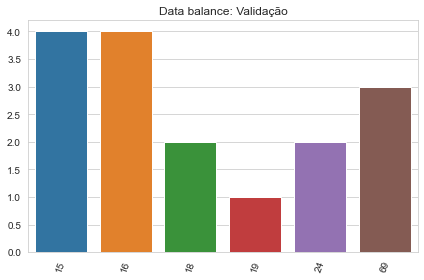

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_holdout_balance(dl, titulo):
    _, labels = next(iter(dl))                            
    sns.set_style('whitegrid')
    print("casos:",len(labels))
    # x -> labels
    # y -> número de ocorrências do label x
    x, y = np.unique(labels, return_counts=True)
    print("número de labels diferentes: ",np.size(x))
    #x_ext=[output_label(n,'ext') for n in x]
    #print([output_label(n,'ext')  for n in x])
    #print(list(map(str, x)))
    #print(y)
    #print(np.sum(y))
    x = x.astype('str')
    #print(x)
    #print(x.dtype)

    grafico=sns.barplot(x, y)
    grafico.set_title(f'Data balance: {titulo}')
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show() 

    
#print("-----------------------------------casos_treino_masculino-----------------------------------")   
#visualize_holdout_balance(train_dl_all_masc, 'Treino')
#print("-----------------------------------casos_validação_masculino-----------------------------------")   
#visualize_holdout_balance(val_dl_all_masc, 'Validação')

#print("-----------------------------------casos_treino_feminimo-----------------------------------")   
#visualize_holdout_balance(train_dl_all_fem, 'Treino')
#print("-----------------------------------casos_validação_feminimo-----------------------------------")   
#visualize_holdout_balance(val_dl_all_fem, 'Validação')


print("-----------------------------------casos_treino_feminimo-----------------------------------")   
visualize_holdout_balance(train_dl_all_uni, 'Treino')
print("-----------------------------------casos_validação_feminimo-----------------------------------")   
visualize_holdout_balance(val_dl_all_uni, 'Validação')


#print("-----------------------------------casos_teste-----------------------------------") 
#visualize_holdout_balance(test_dl_all, 'Teste')

## Métodos: Treino, Avaliação e Previsão

In [57]:
def train_model(h5_file, train_dl, val_dl, model, criterion, optimizer):
    liveloss = PlotLosses()
    for epoch in range(EPOCHS):
        logs = {}
        model.train() 
        running_loss  = 0.0
        running_corrects  = 0.0
        for inputs, labels in train_dl: 
            inputs = inputs.to(device)
            labels = labels.to(device)
            #print(inputs.shape)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_dl.dataset)
        epoch_acc = running_corrects.float() / len(train_dl.dataset)
        logs['loss'] = epoch_loss.item()
        #logs['accuracy'] = epoch_acc.item()
            
        model.eval()
        running_loss  = 0.0
        running_corrects  = 0.0
        for inputs, labels in val_dl: 
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(val_dl.dataset)
        epoch_acc = running_corrects.float() / len(val_dl.dataset)
        logs['val_loss'] = epoch_loss.item()
        # logs['val_accuracy'] = epoch_acc.item()
        liveloss.update(logs)
        liveloss.send()
    
    torch.save(model,h5_file)

In [64]:
from sklearn.metrics import mean_absolute_error

# evaluate the model
def evaluate_model(test_dl, model):
    predictions = []
    actuals = []
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        #inputs = inputs.cpu().to(device)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        inputs, targets = inputs.to(device), targets.to(device)
        yhat = model(inputs)
        yhat = yhat.cpu()
        targets = targets.cpu()
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate mae
    #print(actuals)
    #print(predictions)
    mae = mean_absolute_error(actuals, predictions)
    # calculate mse
    mse = mean_squared_error(actuals, predictions)

    return mae,mse


def make_prediction(model, img):
    #print(img.shape)
    #img = img.reshape(1, 1, 90, 90)
    img = img.reshape(1, 1, PIXELS + ATRIBUTES_NON_PIXEL)
    #print(img.shape)
    #print(img.dtype)
    img = img.to(device) #valves
    prediction = model(img).cpu().detach().numpy()[0][0]
    #print("predictions values: ",model(img).cpu().detach().numpy())
    #prediction = model(img).cpu().detach().numpy()[0].argmax()
    #print("predict:",prediction)
    #img=img.cpu()
    #plt.figure("sample", (20, 10))
    #plt.axis('off')
    #plt.grid(b=None)
    #plt.imshow(img[0,0], cmap=plt.get_cmap('viridis'))
    #plt.show()
    return prediction

###############################################################################################################################################



def create_model(train_dl, val_dl,path_model):
    model = CNNModel_1()
    #print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))
    model.to(device)
    criterion = nn.L1Loss()
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    starttime = time.perf_counter()
    train_model(path_model, train_dl, val_dl, model, criterion, optimizer)
    endtime = time.perf_counter()
    print(f"Tempo gasto: {endtime - starttime} segundos")
    return model


def avaliar_modelo(model,val_dl):
    # evaluate the model
    mae,mse = evaluate_model(val_dl, model)
    print("Evaluate Model")
    print('MAE: %.3f, RMSE: %.3f, MSE: %.3f' % (mae, sqrt(mse), mse))


def predict(indexes,model_file,corr, predictions_val):
    model= torch.load(model_file)
     
    # df -> dataframe com todos os registos 
    df = pd.read_csv("all_data.csv", header=0)
    df = df.sort_values(by=['index'], ascending=True)
    # df_val -> dataframe com apenas os registos que estão dentro do array indexes
    df_indexes = df[df['index'].isin(indexes)] 
    df_indexes = df_indexes.sort_values(by=['index'], ascending=True)
    df_indexes.to_csv('temporario.csv', index=False)
    #display(df_indexes)
    #print(indexes)
    # apenas se apagar pixels 
    apagar_pixels(corr,'temporario.csv')
    dataset = CSVDataset('temporario.csv')
    data_tensor = dataset.get_TensorDataset()
    data_loader = DataLoader(data_tensor, batch_size=BATCH_SIZE, shuffle=False)

    erro = 0
    i = 0
    print("\nVALIDATION PREDICTIONS")
    for i, (imagem, target) in enumerate(data_loader):
        prediction = make_prediction(model,imagem)
        index = int(indexes[i])
        #print("target:",target)
        #print("index:",index)
        #print("age",df.iloc[index]['age'])
        #print("prediction:",prediction)
        #print("Indice: " , index, " | Sex: ", df.iloc[index]['sex']," | Education: ", df.iloc[index]['education']," | Prediction: ",prediction," | Label: ",df.iloc[index]['age'] , " | Erro: ", abs(prediction-df.iloc[index]['age']))
        new_row = {'Index': index, 'Label':df.iloc[index]['age'] , 'Prediction':prediction,'Erro': abs(prediction-df.iloc[index]['age'])}
        predictions_val = predictions_val.append(new_row, ignore_index=True)
        erro += abs(prediction-df.iloc[index]['age'])
    
    print("ERRRRRRRRRRRRRRRROOOOOOO:",erro/(i+1))
    return predictions_val


def predict_kaggle(indexes,model_file,data_loader,predictions_val):
    model= torch.load(model_file)

    for i, (imagem, target) in enumerate(data_loader):
        prediction = make_prediction(model,imagem)
        index = int(indexes[i])
        #print(imagem)
        #print(target)
        #print(index)
        #print(prediction)
        new_row = {'Index': index, 'Prediction':prediction}
        predictions_val = predictions_val.append(new_row, ignore_index=True)
    
    return predictions_val


In [59]:
def class_age(x):
    if x < AGE_JOVEM: # jovem
        return 0
    elif x > AGE_IDOSO: # adulto
        return 2
    else: # idoso
        return 1

## Modelos

### Model MLP

In [60]:
# from torchinfo import summary
from torchsummary import summary

class CNNModel_1(Module):
    def __init__(self, n_inputs):
        super(CNNModel_1, self).__init__()
        self.hidden1 = Linear(n_inputs, 60)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = torch.nn.ReLU()
        self.hidden2 = Linear(60, 20)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = torch.nn.ReLU()
        self.hidden3 = Linear(20, 5)
        kaiming_uniform_(self.hidden3.weight, nonlinearity='relu')
        self.act3 = torch.nn.ReLU()
        #self.hidden4 = Linear(30, 5)
        #kaiming_uniform_(self.hidden4.weight, nonlinearity='relu')
        #self.act4 = torch.nn.ReLU()
        self.hidden4=Linear(5,1)
        #xavier_uniform_(self.hidden4.weight)
        

    def forward(self, X):
        #print(X.shape)
        X = X.view(X.size(0), -1)
        #print(X.shape)
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.hidden2(X)
        X = self.act2(X)
        X = self.hidden3(X)
        X = self.act3(X)
        #X = self.hidden4(X)
        #X = self.act4(X)
        X = self.hidden4(X)
        #X = self.act4(X)
        return X


## Treinar o modelo MLP

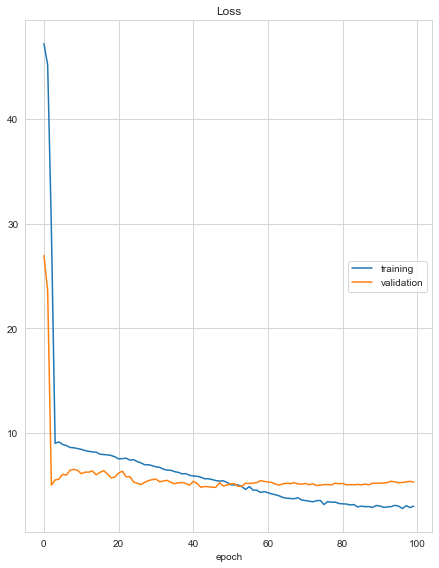

Loss
	training         	 (min:    2.765, max:   47.198, cur:    2.988)
	validation       	 (min:    4.790, max:   26.938, cur:    5.289)
Tempo gasto: 38.14668690000008 segundos


In [61]:

model_uni = CNNModel_1(PIXELS + ATRIBUTES_NON_PIXEL)
#print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))
model_uni.to(device)

EPOCHS = 100
LEARNING_RATE = 0.0005

#EPOCHS = 500
#LEARNING_RATE = 0.00005 
criterion = nn.L1Loss()
optimizer = Adam(model_uni.parameters(), lr=LEARNING_RATE)
starttime = time.perf_counter()
train_model('CNNModel_1_uni.pth', train_dl_uni, val_dl_uni, model_uni, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

## Avaliar o Modelo (o evaluate model está correcto mas as previsões estão com erros) IGNORAR daqui para a frente

In [65]:
# evaluate the model
mae,mse = evaluate_model(val_dl_uni, model_uni)
print("Uni")
print('MAE: %.3f, RMSE: %.3f, MSE: %.3f' % (mae, sqrt(mse), mse))

predictions_val = pd.DataFrame(columns = ['Index', 'Label','Prediction','Erro'])
predictions_val = predict(train_indexes_uni,'CNNModel_1_uni.pth',indexes_corr,predictions_val)

TypeError: 'list' object is not callable

In [ ]:
predictions_val = predictions_val.sort_values(by=['Label'], ascending=True)
display(predictions_val)

,Index,Label,Prediction,Erro
0,0.0,13.0,21.593241,8.593241
1,1.0,14.0,23.137472,9.137472
2,5.0,15.0,28.031092,13.031092
4,10.0,15.0,26.227533,11.227533
7,15.0,15.0,25.760035,10.760035
9,17.0,16.0,20.827650,4.827650
10,18.0,16.0,26.266283,10.266283
5,12.0,16.0,26.641798,10.641798
6,14.0,16.0,15.704098,0.295902
8,16.0,17.0,21.009878,4.009878


In [ ]:
predictions_val = pd.DataFrame(columns = ['Index', 'Label','Prediction','Erro'])

predictions_val = predict(val_indexes_uni,'CNNModel_1_uni.pth',indexes_corr,predictions_val)
predictions_val = predictions_val.sort_values(by=['Label'], ascending=True)
display(predictions_val)

[7464 7642 4588 7970 1786 6859 2604 7588 6575  523 4679 8061 6069 3577
 7824 7646  525 6755 6484  432 6465 6821 6753  345  254 6662  190  902
 6579  883 7733 7555   60 5400  434 6664  533 7475  537 7835 2426 7766
 6843  346 3553 3909 6498 1692 6736 6914 6655 7723  444 7564 4635 4101
 6875 3226 6499 1782 3462 3818 7744  446 2145 6773 6827 7005 7699 4495
 6374 6730 2325 6775 6016 6906 6965 3227  252 6482 4566 5990  343 6573
  210 2702 2721 1920  442 7384 5191 5547 3000 2733 1830 2720 7408 2602
 1346 7754 6502 2052 2882  212 6651 7363 5195 5907 4764 7612 7715 5935
 6063 3037 6421 2861 7006 6917 2524  388 6678 1694 2191 2814 2180 1824
 3326 7776 2513 7497 7679 2695  918 1630 6330 2770 6996 6017 1082  192
 2323 6595 2276 2365 7560   84 7901 6477   18 1620 1524 7576 2054 6682
 2810 1831  151 5491 3486 5978 2147 6953 5068 2576 1697 6948 2517 7857
 2056 6862 2522  208 7867 3417 2143 6593 6506 2412 5755 7713 4228 7966
 4993 3925 5970 2766  374 1264  281  993 7768 2606 5844 7624 8075 5939
 8059 

,index,age,education,sex,18,60,72,84,103,151,...,7857,7867,7901,7966,7970,7992,8059,8061,8065,8075
0,2.0,15.0,0.45,1.0,0.037965,0.000000,0.020054,0.000000,0.012749,0.000000,...,0.000000,0.050968,0.000000,0.000000,0.014634,0.000000,0.000000,0.051479,0.492659,0.021235
1,3.0,15.0,0.45,1.0,0.037018,0.017862,0.000000,0.017414,0.000000,0.000000,...,0.026317,0.082262,0.019479,0.000000,0.012848,0.010068,0.000000,0.023218,0.447766,0.015130
2,4.0,15.0,0.45,1.0,0.038845,0.016830,0.044711,0.026098,0.000000,0.013108,...,0.000000,0.088269,0.000000,0.000000,0.025387,0.000000,0.000000,0.023664,0.440892,0.016533
3,6.0,16.0,0.50,0.0,0.032720,0.000000,0.063499,0.000000,0.000000,0.033922,...,0.000000,0.000000,0.000000,0.000000,0.010253,0.000000,0.000000,0.053832,0.443421,0.021917
4,7.0,16.0,0.50,1.0,0.047430,0.013101,0.012842,0.021563,0.011081,0.000000,...,0.014361,0.021948,0.000000,0.000000,0.016260,0.000000,0.000000,0.017897,0.430117,0.000000
5,8.0,16.0,0.50,0.0,0.037007,0.000000,0.000000,0.000000,0.000000,0.017513,...,0.000000,0.037486,0.000000,0.071776,0.016778,0.015206,0.012511,0.046247,0.415988,0.013020
6,11.0,16.0,0.50,0.0,0.032537,0.024122,0.000000,0.000000,0.000000,0.010695,...,0.035509,0.087128,0.000000,0.000000,0.014814,0.000000,0.000000,0.015395,0.398566,0.000000
7,13.0,15.0,0.45,1.0,0.024422,0.016147,0.012636,0.000000,0.015358,0.019445,...,0.026035,0.032645,0.000000,0.000000,0.020269,0.000000,0.010439,0.052099,0.442632,0.013921
8,19.0,24.0,0.45,1.0,0.045391,0.014907,0.010297,0.000000,0.000000,0.029999,...,0.010180,0.026978,0.023044,0.000000,0.010793,0.000000,0.000000,0.024953,0.520748,0.000000
9,33.0,18.0,0.45,1.0,0.027975,0.011815,0.028443,0.000000,0.000000,0.030563,...,0.031896,0.150673,0.000000,0.013580,0.000000,0.000000,0.000000,0.020174,0.426581,0.000000



VALIDATION PREDICTIONS
ERRRRRRRRRRRRRRRROOOOOOO: 6.8902366161346436


,Index,Label,Prediction,Erro
0,2.0,15.0,23.045919,8.045919
1,3.0,15.0,25.461576,10.461576
2,4.0,15.0,23.668867,8.668867
7,13.0,15.0,26.679556,11.679556
3,6.0,16.0,28.667551,12.667551
4,7.0,16.0,18.829269,2.829269
5,8.0,16.0,24.166166,8.166166
6,11.0,16.0,22.390833,6.390833
9,33.0,18.0,25.505960,7.505960
10,35.0,18.0,21.285234,3.285234


# Previsões Kaggle

In [ ]:
predictions_val_kaggle = pd.DataFrame(columns = ['Index','Prediction','Sex'])

predictions_val_kaggle = predict_kaggle(test_indexes_kaggle_uni,'CNNModel_1_uni.pth',test_dl_uni,predictions_val_kaggle)

predictions_val_kaggle = predictions_val_kaggle.sort_values(by=['Index'], ascending=True)

predictions_kaggle = predictions_val_kaggle[['Index','Prediction']]
predictions_kaggle.columns = ['id', 'age']
predictions_kaggle['id'] = predictions_kaggle['id'] + 1
predictions_kaggle['age'] = round(predictions_kaggle['age'])
predictions_kaggle = predictions_kaggle.astype({"id": int})
predictions_kaggle = predictions_kaggle.astype({"age": int})
predictions_kaggle.to_csv('predictions_kaggle.csv', index=False)
display(predictions_kaggle)

C:\Users\jlame\AppData\Local\Temp/ipykernel_28108/3379537583.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_kaggle['id'] = predictions_kaggle['id'] + 1
C:\Users\jlame\AppData\Local\Temp/ipykernel_28108/3379537583.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_kaggle['age'] = round(predictions_kaggle['age'])


,id,age
0,1,27
1,2,29
2,3,25
3,4,26
4,5,22
5,6,25
6,7,61
7,8,48
8,9,57
9,10,62
